# Magic the Gathering Price Predictor
## Summary:
The purpose of this notebook is to output price predictions for modern staples as determined by a pretrained LSTM RNN. This neural network is trained on historical price and tournament play data, using a 30 day lag time and makes predictions for 7 days into the future. There are over 300 cards in the dataset and there are options for keeping the dataset up to date in this notebook. All of the tournament and price data are scraped from MTGGoldfish. 

In [3]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mpld3
import pandas as pd
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from SeriesToSupervised import difference, diff_scale, forecast_lstm
from SeriesToSupervised import inverse_difference, inverse_transform, series_to_supervised
from SeriesToSupervised import prepare_data, getRidgePred

Using TensorFlow backend.


## Card Selection
Here you may select a card from the dataset. Price and tournament play data will be loaded and price predictions will be made for this card. Some suggestions: 'Snapcaster Mage', 'Tarmogoyf', 'Chalice of the Void', 'Teferi, Hero of Dominaria', 'Kolaghan\'s Command', 'Jace, the Mind Sculptor'

In [1]:
#Select a card
card = 'Lyra Dawnbringer'

You may run this cell to return the full list of cards in the dataset

In [ ]:
Prices = pd.read_csv('All_Prices.csv')
Card_list = list(Prices.keys()[1:])
Card_list.sort()
for c in Card_list:
    print(c)

## Load the Predictions
### Running this cell completes the following actions: 
-Load price and tournament play data 
<br/> -Load the trained neural network and generate predictions
<br/> -Train a ridge regressor on the price data and return predictions

In [4]:
#Load pretrained LSTM model
model = load_model('Train_on_14.h5')

#Load price data
Prices = pd.read_csv('All_Prices.csv')
Prices['Date'] = pd.to_datetime(Prices['Date'])
Price = Prices[['Date',card]]
Price = Price.fillna(method='ffill')
Price = Price.dropna()

#Load Tournament Data
Copies = pd.read_csv('Copies_Played_Culled.csv')
Copies['Date'] = pd.to_datetime(Copies['Date'])
Copies = Copies.set_index('Date')
Resamp = Copies.resample('D').sum()

#Converting to meta_share for predictions
Resamp['Meta_Share'] = Resamp[card]/Resamp['Total']
Resamp['Date'] = Resamp.index
df_test = Price.merge(Resamp[['Meta_Share']],
                      how='outer', left_on = 'Date', right_on = 'Date')
df_test = df_test.sort_values(by='Date')
df_test = df_test.fillna(method='ffill')
df_test.dropna(inplace=True)
df_test = df_test.set_index('Date')

#Do not change these parameters, the NN takes a 30 day lag as input
n_lag = 30
n_seq = 7
n_test = int(len(df_test)/6)

#Converting time-series data to supervised learning format
scaler_p, dataset_p = diff_scale(df_test[card])
scaler_m, dataset_m = diff_scale(df_test['Meta_Share'])

X_pred = np.concatenate((dataset_p[-30:], dataset_m[-30:]))
y_scaled = forecast_lstm(model,X_pred,1)

#Getting NN predictions
Future_NN = inverse_transform(df_test[card].values[-1],y_scaled,scaler_p)
Future_NN = np.append(df_test[card].values[-1],Future_NN)
f_list_NN = [[df_test.index[-1] +
           pd.tseries.offsets.DateOffset(i),Future_NN[i]] for i in range(0,n_seq+1)]

df_fut_NN = pd.DataFrame(data = f_list_NN, columns=['Date','Price'])
df_fut_NN = df_fut_NN.set_index('Date')

#fitting ridge regressor and getting predictions
df_fut_R = getRidgePred(df_test[card],n_test,n_lag,n_seq)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/opt/conda/envs/data3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Plotting 
The next few cells are for visualizing the predictions. Here are the options: <br/>
-Set plot_tournament to True for a non-interactable plot of historical price and tournament play data superimposed on the same axes. <br/>
-Set plot_tournament to False for an interactable plot of historical price data and both the Neural Network and Ridge price predictions.

In [5]:
plot_tournament = False #Set to true if you want to also see tournament play frequency

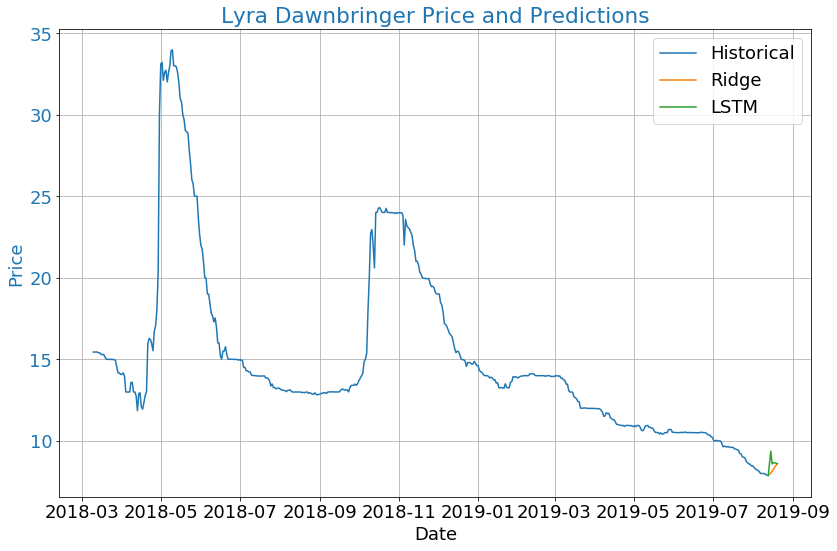

In [6]:
#Run this cell to plot prepared data and predictions

%matplotlib inline
mpld3.enable_notebook()

matplotlib.rcParams.update({'figure.figsize':[12,8],'font.size': 18})
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(df_test.index,df_test[card],color = color)
ax1.plot(df_fut_R.index,df_fut_R.Price, 'tab:orange')
ax1.plot(df_fut_NN.index,df_fut_NN.Price, 'tab:green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.set_title(card+ ' Price and Predictions', color=color)
ax1.legend(['Historical','Ridge','LSTM'])
ax1.grid()


if plot_tournament:
    color = 'tab:red'
    mpld3.disable_notebook()
    ax2 = ax1.twinx()
    weekly = Copies.resample('W').sum()
    weekly['Meta_Share'] = weekly[card]/weekly['Total']
    ax2.plot(weekly.index,weekly.Meta_Share,color = color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Tournament Play Frequency', color=color)
    ax2.grid()
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Updating the dataset
### WARNING: This takes a while to run
Run this cell to update the csv's storing price and tournament play data. This is done via webscraping on MTGGoldfish

In [ ]:
import DataIngestion

DataIngestion.Update_Tourneys(2)
DataIngestion.UpdatePrices()